# Кейс - Приложение знакомств


Механика приложения для онлайн-знакомств следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

**Цель проекта** — оценить, улучшил ли новый алгоритм качество сервиса. Для этого выбраны соответствующие метрики, которые отвечают за качество сервиса, и проведено статистическое сравнение этих метрик между двумя группами. В данных содержится информация о логах взаимодействия пользователей, из какой они группы АБ-теста и случился ли у них мэтч.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

**Результат проекта** — аналитическое заключение с рекомендацией о том, стоит ли внедрять новую систему поиска анкет для всех пользователей.


### Датасет

Таблица содержит следующие поля:

- **user_id_1**: идентификатор первого пользователя
- **user_id_2**: идентификатор второго пользователя
- **group**: группа АБ-теста (0 - старый алгоритм, 1 - новый алгоритм)
- **match**: случился ли мэтч (1 - да, 0 - нет)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

In [37]:
def url_ydisk (url):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = url

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    return download_url

In [38]:
# Чтение данных
df = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/txn7q-CE2zSaPg'))
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [4]:
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [5]:
df.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

In [41]:
df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [42]:
# Сколько наблюдений в каждой группе
df.groupby("group").is_match.count()

group
0    4792
1    9722
Name: is_match, dtype: int64

In [43]:
# Сколько юзеров в каждой группе
df.groupby("group").user_id_1.nunique()

group
0    501
1    499
Name: user_id_1, dtype: int64

In [44]:
df.groupby("group").user_id_2.nunique()

group
0    501
1    499
Name: user_id_2, dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df.describe()

,user_id_1,user_id_2,group,is_match
count,14514.000000,14514.000000,14514.000000,14514.000000
mean,500.220132,501.843737,0.669836,0.333678
std,288.703825,287.250879,0.470288,0.471542
min,1.000000,1.000000,0.000000,0.000000
25%,253.000000,255.000000,0.000000,0.000000
50%,504.000000,500.000000,1.000000,0.000000
75%,751.000000,752.750000,1.000000,1.000000
max,1000.000000,1000.000000,1.000000,1.000000


Нет ли пересечения между группами пользователей? Для проверки этого нам пригодятся множества:

In [12]:
gr_01 = set(df.query("group==0").user_id_1)
gr_11 = set(df.query("group==1").user_id_1)

gr_01.intersection(gr_11)

set()

In [13]:
gr_02 = set(df.query("group==0").user_id_2)
gr_12 = set(df.query("group==1").user_id_2)

gr_02.intersection(gr_12)

set()

# Гипотезы и стат тесты

### Гипотеза 1:  изменилось соотношение мэтчей и не-мэтчей

Основная метрика — бинарная переменная is_match, которая указывает на то, произошел ли мэтч между пользователями.

Посмотрим на кросстабуляцию:

In [14]:
pd.crosstab(df.group, df.is_match)

is_match,0,1
group,,
0,3858,934
1,5813,3909


In [32]:
df.groupby('group')['is_match'].sum()

group
0     934
1    3909
Name: is_match, dtype: int64

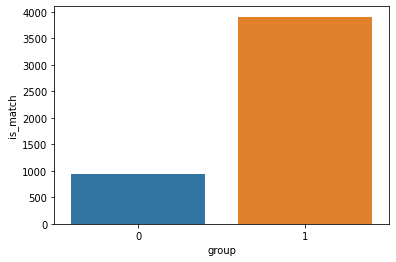

In [36]:
# Построение графика распределения мэтчей по группам
sns.barplot(x='group', y='is_match', data=df.groupby('group', as_index=False)['is_match'].sum())

Количество мэтчей в тестовой группе возросло - однако увеличилось и количество не-мэтчей, по сравнению с контрольной группой. 

Имеем две категориальные переменные (group/is_match) → воспользуемся тестом хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [15]:
# Проверка тестом хи-квадрат
stat, p_value, dof, expecte = ss.chi2_contingency(pd.crosstab(df.group, df.is_match))

In [16]:
p_value < 0.05 

True

**Вывод:** p-value < 0.05 → существует статистически значимое различие между группами. Новый алгоритм эффективен в рамках данной метрики.

### Гипотеза 2: изменилось число анкет на пользователя

In [47]:
prof_per_user = df.groupby(["group", "user_id_1"], as_index=False).size()
prof_per_user

,group,user_id_1,size
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20
...,...,...,...
995,1,987,23
996,1,992,21
997,1,993,18
998,1,998,18


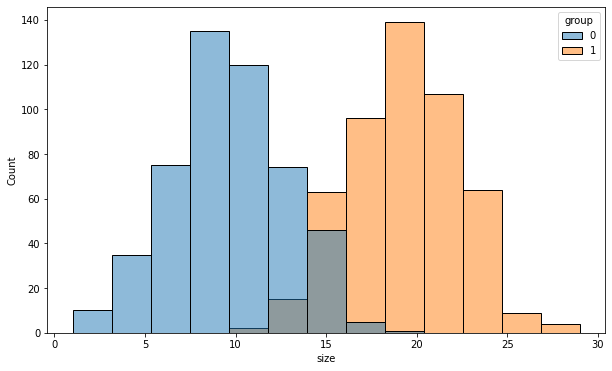

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(data=prof_per_user, x="size", hue="group")

На первый взгляд количество анкет в тестовой группе увеличилось в сравнении с контрольной. Убедимся с помощью стат теста.

In [64]:
control_prof_per_user = prof_per_user.query('group == 0')['size']
test_prof_per_user = prof_per_user.query('group == 1')['size']

Чтобы выбрать стат тест, проведем тест на нормальность распределений переменных.

In [61]:
print(ss.normaltest(control_prof_per_user))
print(ss.normaltest(test_prof_per_user))

NormaltestResult(statistic=2.4061675155374465, pvalue=0.300266832562874)
NormaltestResult(statistic=4.262188990750171, pvalue=0.11870729813673236)


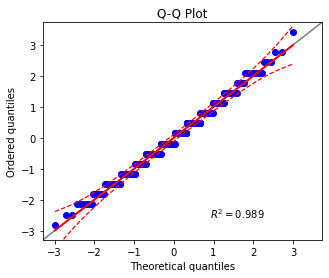

In [65]:
pg.qqplot(control_prof_per_user)

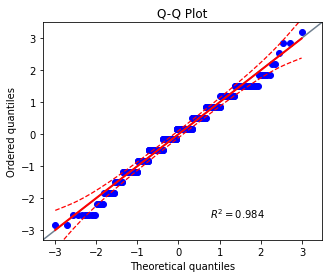

In [66]:
pg.qqplot(test_prof_per_user)

В ходе неоднократной проверки пришли к выводу, что переменные распределены нормально.


Имеем две непрерывные переменные (control_prof_per_user/test_prof_per_user), рапределение которых нормально → воспользуемся t-тестом.

- $H_0$: Средние значения для двух групп равны.
- $H_1$: Средние значения для двух групп не равны.

In [67]:
# Проведение ttest
t_stat, p_value = ss.ttest_ind(control_prof_per_user, test_prof_per_user)
t_stat, p_value 

(-51.85383774946492, 1.8942877064043142e-285)

In [68]:
p_value < 0.05 

True

**Вывод:** p-value < 0.05 → существует статистически значимое различие между группами. Новый алгоритм эффективен в рамках данной метрики.

### Гипотеза 3: изменилось число мэтчей на пользователя

In [69]:
# Подсчет количества мэтчей и пользователей в каждой группе 
# df.query('group == 0').is_match.sum() / df.query('group == 0').is_match.shape[0]
match_rate = df.groupby('group')['is_match'].mean().reset_index()
match_rate

,group,is_match
0,0,0.194908
1,1,0.402078


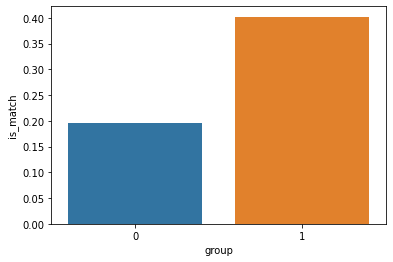

In [70]:
# Построение графика распределения мэтчей по группам
sns.barplot(x='group', y='is_match', data=match_rate)

In [71]:
control_matches = df.query('group == 0').is_match
test_matches = df.query('group == 1').is_match

Чтобы выбрать стат тест, проведем тест на нормальность распределений переменных.

In [72]:
print(ss.normaltest(control_matches))
print(ss.normaltest(test_matches))

NormaltestResult(statistic=1056.7389057083074, pvalue=3.4045696177523702e-230)
NormaltestResult(statistic=37375.72668370961, pvalue=0.0)


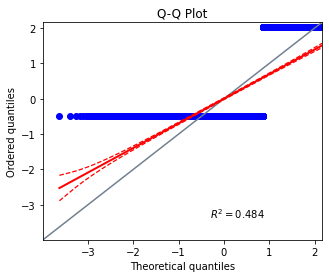

In [73]:
pg.qqplot(control_matches)

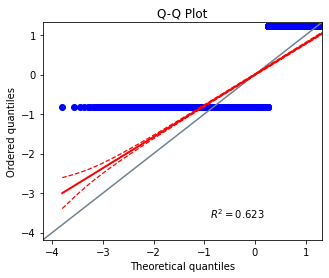

In [74]:
pg.qqplot(test_matches)

В ходе неоднократной проверки пришли к выводу, что переменные распределены ненормально.

Имеем две дискретные переменные (control_matches/test_matches), рапределение которых ненормально → нужен критерий Манна-Уитни

- $H_0$: Распределения переменной is_match для двух групп равны.
- $H_1$: Распределения переменной is_match для двух групп не равны.

In [76]:
# Проведение теста Манна-Уитни
u_stat, p_value = ss.mannwhitneyu(control_matches, test_matches)
u_stat, p_value

(18468122.0, 9.239398092772123e-137)

In [77]:
p_value < 0.05 

True

**Вывод:** p-value < 0.05 → существует статистически значимое различие между группами.

# Заключение
На основании проведенного АБ-теста, оценивавшего эффективность нового алгоритма поиска анкет в приложении для онлайн-знакомств, были проверены три гипотезы.

Все три гипотезы показали статистически значимые различия между группами, что указывает на улучшение качества сервиса при использовании нового алгоритма. Следовательно, рекомендуется включить новую систему поиска анкет для всех пользователей приложения.






